<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/random_walks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Random Walks

In this notebook, we implemented a variety of random walks based on the main class `Walker`. All the random walker operates over a graph, which has nodes in a lattice configuration, and just connections to the near four neighbors are allowed (top, bottom, left, right).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/

/content/gdrive/MyDrive/Proyectos/aco_random_walk


In [3]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import random
import os
import pandas as pd
from collections import Counter
import math

#own functions
import model.graph_env as ge
import utils.visualization as vis
import utils.measures as measures

In [4]:
DATA_DIR = "stuff/data/random_maze/"
SAVING_DIR = "stuff/results/aco_pp/"
RANDOM_WALK_DIR = SAVING_DIR + "random_walks/"

if not os.path.exists(DATA_DIR):
  os.mkdir(DATA_DIR)

if not os.path.exists(SAVING_DIR):
  os.mkdir(SAVING_DIR)

if not os.path.exists(RANDOM_WALK_DIR):
  os.mkdir(RANDOM_WALK_DIR)

# Base Walker class

This is the base walker class which defines the way to deposit pheromones and some basic operations.

In [5]:
class Walker():
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001):
    
  
    self.graph = graph
    self.q_0 = q_0
    self.size = graph.size
    self.start_node = 0
    self.target_node = graph.size * graph.size - 1
    self.reset_walk()

  def reset_walk(self):
    self.current_path = []
    self.current_position = self.start_node
    self.visited_nodes = []

  def get_distance_path(self):
    total_distance = 0
    for node1, node2 in self.current_path:
      pos1 = self.graph.nodes[node1]['pos']
      pos2 = self.graph.nodes[node2]['pos']
      total_distance += measures.get_distance(pos1, pos2, 'euclidean')

    return total_distance

  def end_route(self):
    return self.current_position == self.target_node

  def walk(self, num_rand_walks):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      self.reset_walk()

      is_complete = False

      while not is_complete:
        self.update_step()

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(self.get_distance_path())

    return distances_list

# Proximity Random Walker

This random walker is with tendency based on the proximity measure, which represents the distance from the neighbor node to the target node. In this way, the random walks follows the following decision-making algorithm in each step.

Let the node $i$, the probability of move from node $i$ to node $j$ is

$$ p_{i j}^{k}= \frac{\upsilon_{i j} }{\sum_{n_{i l} \in \mathrm{N}(s^{p})} \upsilon_{i l}}  \quad \text{if} \quad n_{ij} \in \mathbf{N}_i $$



where $\mathrm{N}_i$ is the set of feasible neighbors nodes, and $\upsilon_{ij}$ is the proximity of the neighbor node $j$ respect to the current node $i$.

In this way, the algorithm encourages to the walker to direct to the target node whereas mantains its random behavior.

Here according to the relevant proximities and normalization we evaluated different random walkers. Also, we decide to test only local normalization because it present more interesting variations.

In [13]:
class ProximityWalker(Walker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001,
               proximity_mode = 'proximity_1', distance_type = 'euclidean', 
               normalization = None):
    
    self.proximity_mode = proximity_mode
    self.distance_type = distance_type
    self.normalization = normalization
    super().__init__(graph, q_0, reward_tau)


  def update_step(self):
    neighbors = self.graph[self.current_position]

    weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():
        # get the weight per neighbor
        weights.append(measures.get_proximity(self.graph, 
                                     self.current_position,
                                     neighbor_node, 
                                     self.target_node,
                                     self.proximity_mode,
                                     self.distance_type))
        neighbors_idx.append(neighbor_node)

    # applied local normalization
    if normalization is not None:
      weights = measures.normalize_array(weights, self.normalization)
      

    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      #print("[INFO] probabilities: {}".format(probabilities))

      # choose an option following the wheel selection algorithm  
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

In [18]:
type_rw = "proximity"
proximities_options = ['proximity_1', 'proximity_2']
distances_options = ['euclidean', 'manhattan']
normalization_options = [ 'none', 'l2-norm', 'max-min']
q_0_options = [0. , 0.3, 0.5, 0.7, 0.9]

num_rand_walks = int(10)

# Create the graph
graph = ge.PPGraph(size = 10, tau_0 = 0.1)

dir_results = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}")
if not os.path.exists(dir_results):
  os.makedirs(dir_results)

dict2plot = {}
for proximity in proximities_options:
  for distance in distances_options:
    for normalization in normalization_options:
      for q_0 in q_0_options:


        # Create the walker
        walker = ProximityWalker(graph, 
                                q_0 = q_0, 
                                reward_tau = 0.0001,
                                proximity_mode = proximity,
                                distance_type = distance,
                                normalization = normalization)

        # Perform the walk
        distances_list = walker.walk(num_rand_walks = num_rand_walks)
        
        base_name = "{}_{}_{}_{}".format(
            proximity,
            distance,
            normalization,
            q_0)
        
        dict2plot[base_name] = np.array(distances_list)

        file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}/{base_name}.npy")
        np.save(file_name, np.array(distances_list))

file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}.npz")
np.savez(file_name, **dict2plot)      

In [16]:
proximity_values = os.listdir(RANDOM_WALK_DIR)
proximity_values

['rw_size_10.npz', 'rw_proximity_size_10.npz']

[Load] proximities data:  stuff/results/aco_pp/random_walks/rw_proximity_size_10.npz


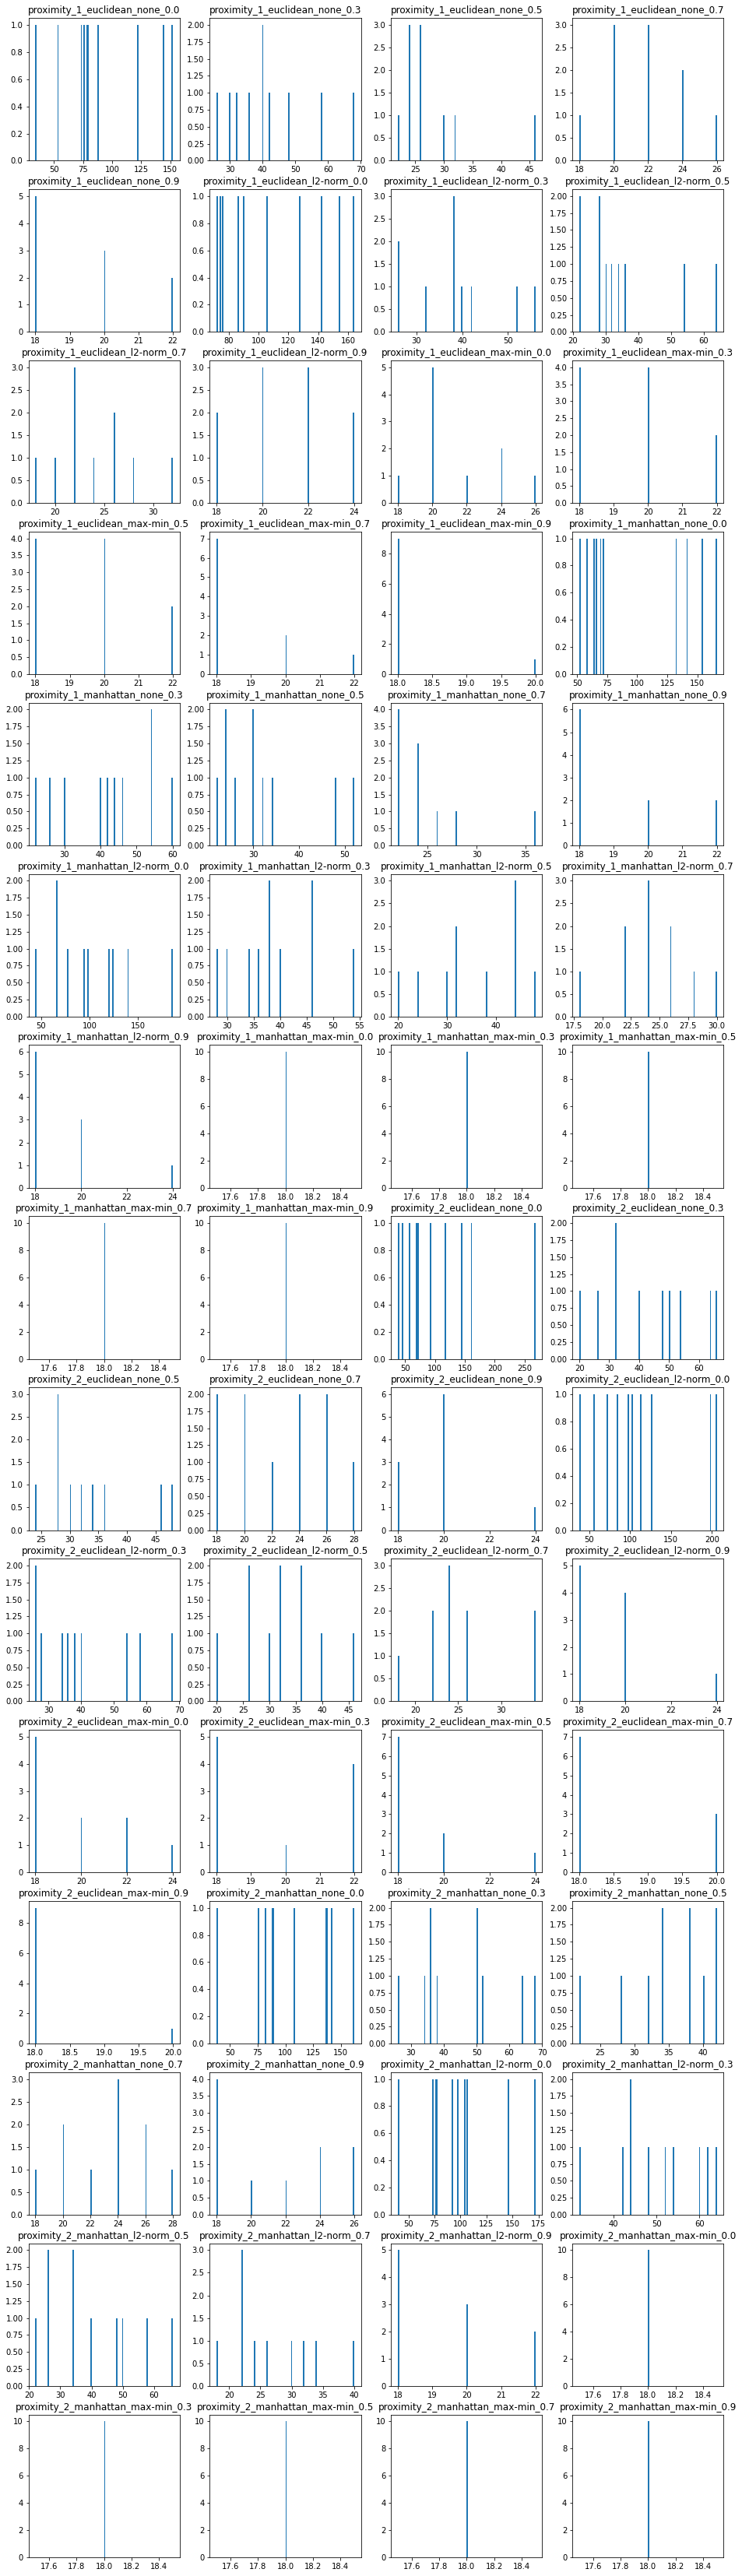

In [17]:
vis.plot_histograms(filename=os.path.join(RANDOM_WALK_DIR,"rw_proximity_size_10.npz"),bins = 100)

## Greedy Walker



In [6]:
class GreedyWalker(Walker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001, advantage = 3):

    self.advantage = advantage
    super().__init__(graph, q_0, reward_tau)

  def get_greedy_favorites(self, location = ('bottom','right') ):
    
    favorites_nodes = []
    if location[1] == 'right':
      favorites_nodes.append(self.current_position + 1)
    elif location[1] == 'left':
      favorites_nodes.append(self.current_position - 1)

    if location[0] == 'bottom':
      favorites_nodes.append(self.current_position + self.size)
    elif location[0] == 'top':
      favorites_nodes.append(self.current_position - self.size)

    return favorites_nodes

  def update_step(self):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]
    favorites = self.get_greedy_favorites()
    weights = [ self.advantage if n in favorites else 1 for n in neighbors_idx ]


    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
      # arg_max = np.argwhere(weights == np.amax(weights))
      # new_position = np.random.choice(arg_max.flatten(), 1)[0]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
      # print("[INFO] probabilities: \t {}".format(probabilities))

      # choose an option following the wheel selection algorithm 
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

In [7]:
type_rw = "greedy"

advantage_options = [2,2.5,3]
q_0_options = [0, 0.3, 0.5, 0.7, 0.9]
num_rand_walks = int(10)

# Create the graph
graph = ge.PPGraph(size=10, tau_0=0.1)

dir_results = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}")
if not os.path.exists(dir_results):
  os.makedirs(dir_results)

dict2plot = {}

for advantage in advantage_options:
  for q_0 in q_0_options:


    # Create the walker
    walker = GreedyWalker(graph, 
                          q_0 = q_0, 
                          advantage = advantage)
    
    # Perform the walk
    distances_list = walker.walk(num_rand_walks)
    
    base_name = "advantage_{}_q0_{}".format(
        advantage,
        q_0)
    
    dict2plot[base_name] = np.array(distances_list)

    file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}/{base_name}.npy")
    np.save(file_name, np.array(distances_list))

file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}.npz")
np.savez(file_name, **dict2plot) 

In [8]:
!ls $RANDOM_WALK_DIR

rw_greedy_size_10      rw_proximity_size_10
rw_greedy_size_10.npz  rw_proximity_size_10.npz


[Load] proximities data:  stuff/results/aco_pp/random_walks/rw_greedy_size_10.npz


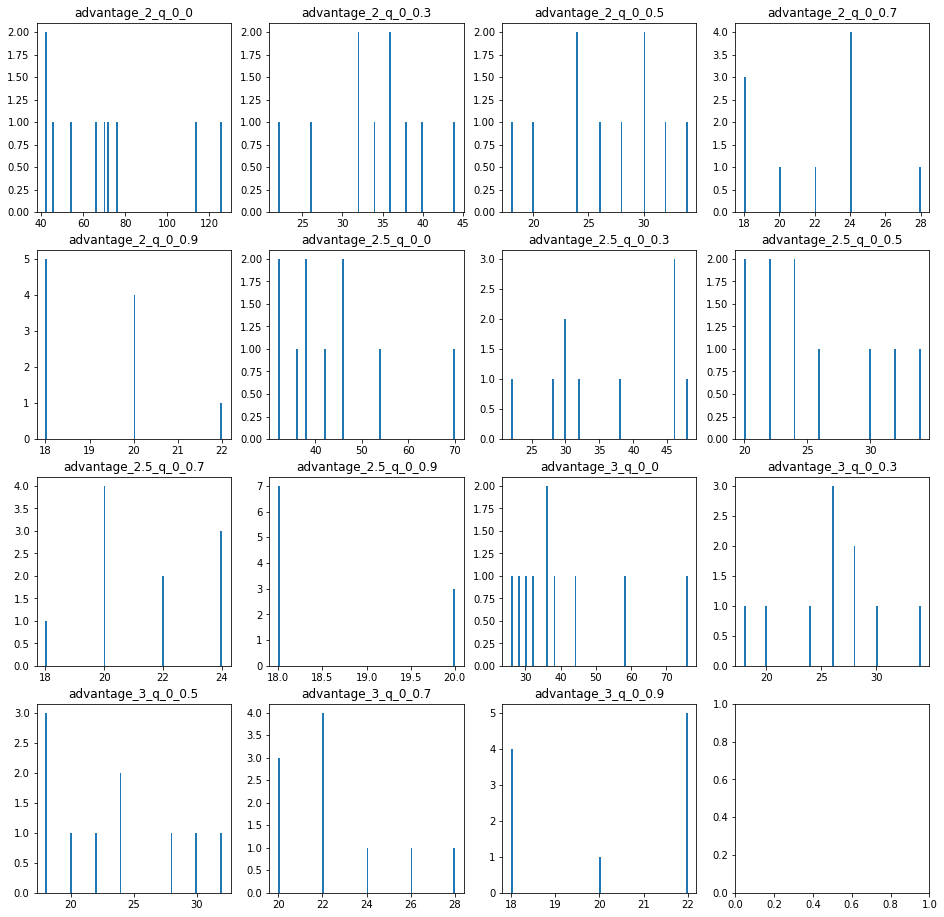

In [11]:
vis.plot_histograms(filename=os.path.join(RANDOM_WALK_DIR,"rw_greedy_size_10.npz"),bins = 100)

# Levy Floght + Proximity Walker

In [17]:
class LevyFlightProximityWalker(ProximityWalker):
  def __init__(self, graph, q_0 = None,
               omega = 1, 
               reward_tau = 0.0001,
               proximity_mode = 'proximity_1', 
               distance_type = 'euclidean', 
               normalization = None):
    # omega clustering exponent

    self.omega = omega # [1-3]

    super().__init__(graph, q_0, reward_tau, 
                     proximity_mode, 
                     distance_type, 
                     normalization)

  def update_step(self):

    # get the neighbors of the current node
    neighbors = self.graph[self.current_position]
    neighbors_idx = [n for n, edge in neighbors.items()]

    # build a list with the possible long range connections
    # here we do not included the neighbors nor the start node
    # or target node
    excluding_idx = neighbors_idx + [self.current_position]
    pos_connections = [ n for n in np.arange(self.start_node + 1, self.target_node) if n not in excluding_idx]

    long_range_node = np.random.choice(pos_connections)

    dist_current2long_range = measures.get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'],
                                           'euclidean')

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
      self.current_path.append((self.current_position, new_position))
      self.visited_nodes.append(new_position)
      self.current_position = new_position
    else:
      super().update_step()

In [25]:
type_rw = "levy_proximity"
proximities_options = ['proximity_1', 'proximity_2']
distances_options = ['euclidean', 'manhattan']
normalization_options = [ 'none', 'l2-norm', 'max-min']
q_0_options = [0. , 0.3, 0.5, 0.7, 0.9]
omega_options = [0.5, 1, 2, 3, 4]
num_rand_walks = int(10)

# Create the graph
graph = ge.PPGraph(size = 10, tau_0 = 0.1)

dir_results = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}")
if not os.path.exists(dir_results):
  os.makedirs(dir_results)

dict2plot = {}
for proximity in proximities_options:
  for distance in distances_options:
    for normalization in normalization_options:
      for q_0 in q_0_options:
        for omega in omega_options:


          # Create the walker
          walker = LevyFlightProximityWalker(graph, 
                                  q_0 = q_0, 
                                  reward_tau = 0.0001,
                                  omega = omega,
                                  proximity_mode = proximity,
                                  distance_type = distance,
                                  normalization = normalization)

          # Perform the walk
          distances_list = walker.walk(num_rand_walks = num_rand_walks)
          
          base_name = "{}_{}_{}_{}_omega_{}".format(
              proximity,
              distance,
              normalization,
              q_0,
              omega)
          
          dict2plot[base_name] = np.array(distances_list)
          print("Saving ... {}".format(base_name))
          file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}/{base_name}.npy")
          np.save(file_name, np.array(distances_list))

file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}.npz")
np.savez(file_name, **dict2plot)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Saving ... proximity_1_euclidean_none_0.0_omega_0.5
Saving ... proximity_1_euclidean_none_0.0_omega_1
Saving ... proximity_1_euclidean_none_0.0_omega_2
Saving ... proximity_1_euclidean_none_0.0_omega_3
Saving ... proximity_1_euclidean_none_0.0_omega_4
Saving ... proximity_1_euclidean_none_0.3_omega_0.5
Saving ... proximity_1_euclidean_none_0.3_omega_1
Saving ... proximity_1_euclidean_none_0.3_omega_2
Saving ... proximity_1_euclidean_none_0.3_omega_3
Saving ... proximity_1_euclidean_none_0.3_omega_4
Saving ... proximity_1_euclidean_none_0.5_omega_0.5
Saving ... proximity_1_euclidean_none_0.5_omega_1
Saving ... proximity_1_euclidean_none_0.5_omega_2
Saving ... proximity_1_euclidean_none_0.5_omega_3
Saving ... proximity_1_euclidean_none_0.5_omega_4
Saving ... proximity_1_euclidean_none_0.7_omega_0.5
Saving ... proximity_1_euclidean_none_0.7_omega_1
Saving ... proximity_1_euclidean_none_0.7_omega_2
Saving ... proximity_1_euclidean_none_0.7_omega_3
Saving ... proximity_1_euclidean_none_0.7_

In [26]:
class LevyFlightGreedyWalker(GreedyWalker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001, omega = 2, advantage = 3):
    # omega clustering exponent

    self.omega = omega # [1-3]

    super().__init__(graph, q_0, reward_tau, advantage)

  def update_step(self):

    # get the neighbors of the current node
    neighbors = self.graph[self.current_position]
    neighbors_idx = [n for n, edge in neighbors.items()]

    # build a list with the possible long range connections
    # here we do not included the neighbors nor the start node
    # or target node
    excluding_idx = neighbors_idx + [self.current_position]
    pos_connections = [ n for n in np.arange(self.start_node + 1, self.target_node) if n not in excluding_idx]

    long_range_node = np.random.choice(pos_connections)

    dist_current2long_range = measures.get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'],
                                           'euclidean')

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
      self.current_path.append((self.current_position, new_position))
      self.visited_nodes.append(new_position)
      self.current_position = new_position
    else:
      super().update_step()

In [29]:
type_rw = "levy_greedy"

advantage_options = [2,2.5,3]
q_0_options = [0.5, 0.3, 0.5, 0.7, 0.9]
omega_options = [0.5,1, 2, 3, 4]
num_rand_walks = int(10)

# Create the graph
graph = ge.PPGraph(size=10, tau_0=0.1)

dir_results = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}")
if not os.path.exists(dir_results):
  os.makedirs(dir_results)

dict2plot = {}

for advantage in advantage_options:
  for q_0 in q_0_options:
    for omega in omega_options:


      # Create the walker
      walker = LevyFlightGreedyWalker(graph, 
                                      q_0 = q_0,
                                      omega = omega,
                                      advantage = advantage)
      
      # Perform the walk
      distances_list = walker.walk(num_rand_walks)
      
      base_name = "advantage_{}_q0_{}_omega_{}".format(
          advantage,
          q_0,
          omega)
      
      dict2plot[base_name] = np.array(distances_list)
      print("Saving ... {}.npy".format(base_name))

      file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}/{base_name}.npy")
      np.save(file_name, np.array(distances_list))

file_name = os.path.join(RANDOM_WALK_DIR,f"rw_{type_rw}_size_{graph.size}.npz")
np.savez(file_name, **dict2plot) 

Saving ... advantage_2_q0_0.5_omega_0.5.npy
Saving ... advantage_2_q0_0.5_omega_1.npy
Saving ... advantage_2_q0_0.5_omega_2.npy
Saving ... advantage_2_q0_0.5_omega_3.npy
Saving ... advantage_2_q0_0.5_omega_4.npy
Saving ... advantage_2_q0_0.3_omega_0.5.npy
Saving ... advantage_2_q0_0.3_omega_1.npy
Saving ... advantage_2_q0_0.3_omega_2.npy
Saving ... advantage_2_q0_0.3_omega_3.npy
Saving ... advantage_2_q0_0.3_omega_4.npy
Saving ... advantage_2_q0_0.5_omega_0.5.npy
Saving ... advantage_2_q0_0.5_omega_1.npy
Saving ... advantage_2_q0_0.5_omega_2.npy
Saving ... advantage_2_q0_0.5_omega_3.npy
Saving ... advantage_2_q0_0.5_omega_4.npy
Saving ... advantage_2_q0_0.7_omega_0.5.npy
Saving ... advantage_2_q0_0.7_omega_1.npy
Saving ... advantage_2_q0_0.7_omega_2.npy
Saving ... advantage_2_q0_0.7_omega_3.npy
Saving ... advantage_2_q0_0.7_omega_4.npy
Saving ... advantage_2_q0_0.9_omega_0.5.npy
Saving ... advantage_2_q0_0.9_omega_1.npy
Saving ... advantage_2_q0_0.9_omega_2.npy
Saving ... advantage_2_q

Uno de los problemas sobresalientes en problemas de decision es la cantidad de estados presentes y las posibles acciones. Cuando este numero empieza a subir mucho, los algoritmos empiezan a subir problemas [consultar]. Es una area muy estudiada ttatatatat . En el presente paper se pretende estudiar este comportamiento mediante una aplicacion muestra o un escenario de juguete en donde se puede compreder de manera experimental la difficultad de alcanzar valores optimos cuando el numero de estados crece y las acciones posibles se limitan. En este caso particular se utilizo un ACO para demostrar nuestra hypothesis, que puede ser considerado a breves rasgos como un RL algorimo por su esencia de refuerzo y tal tal. Sin embargo, se pretende que sea el pilas esencial para un investigacion mas profunda de este estilo.  

1. Uno de los problemas con este tipo de algoritmos parece ser la cantidad de estados que empieza a elevarse. En un ambiente libre de obstaculos resulta sencillo resolver el problema. Sin embargo a medida que se aumentan los estados y los obstaculos presentes en el ambiente el algoritmo empieza a fallar. Existen ciertas metodo que resuelven el problema desde diferentes escenarios como algoritmos por REFUERZO, .. .. .. . En este paper, la idea es implementar cierta inicializacion de fermonas con el objetivo de superar este problema. Aunque el paper abordara un problema de combinacion bastante fundamental. El paper pretende servir como un fundamento para emplear estas mismas ideas en escenarios más complejos.

Hipotesis: proveer al algoritmo de cierto informacion (conocimiento) inicial por medio de la inicialización de fermonos siguiendo random walks. De cierta manera se espera que los random walks logren lidiar con el problema de estados y obstaculos y a su vez mejorar los tiempos de convergencia de los escenerios ya estudiados.

En general, el presente proyecto intenta abordar el problema de planificacion de ruta o path finding. Sin embargo, se podria escalar la inicializacion por random walks a escenarios más complejos e incluso a otros enfoques como algoritmos de reinforcement learning cuya esencia es optimizar la recompensa futura in a long term. Esta en escencia relacionado al algoritmo ACO por el refuerzo que recibe de las fermonos. Sin embargo, RL algoritmos implementan algoritmos más robustos.

Estudiarlo con algoritmos de refuerzo mas actuales, mas robustos donde exista cierta información suycente (como las fermonas en este caso) que aceleren el aprendizaje. Sin embargo, no necesariamente se buscaria alterar las recompensas en dichos algoritmos, ya que su actualización romperia la esencia de un algoritmo por refuerzo.